## Problem Set 2: Merging and regular expressions

**Total points (without extra credit)**: 30 

**Background on the policy context**: here, we're going to use two datasets to practice reshaping, merging, and regular expression patterns. Both datasets relate to the broader issue of which employers might be violating the rights of temporary guestworkers granted visas under the H-2A program. Here are some articles about potential exploitation of guestworkers by firms and inequality caused by minimal oversight:

- News media coverage of labor abuses of temporary guestworkers: https://www.buzzfeednews.com/article/kenbensinger/the-pushovers 
- GAO report on labor abuses of temporary guestworkers: https://www.gao.gov/products/gao-15-154

The following datasets are located in `pset2_inputdata` (need to unzip): 

- `jobs_clean`: a dataset of guestworker jobs posted by many employers, some of whom have been debarred (banned) from the program for labor abuses; others not debarred
- `debar`: a dataset of employers who committed violations of labor regulations meant to protect temporary guestworkers 


You can view a codebook here: https://docs.google.com/spreadsheets/d/1rF9GJEC8pPKxipD0TsoG9DVdqz3EJ-b-BHEtyioAX7I/edit?usp=sharing


In [12]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import os

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 1. Reshaping data (13 points total)

Load the following dataset stored in `pset2_inputdata`: `debar.csv`

This represents employers temporarily banned from hiring workers (debar.csv); call this `debar`


View the head()


In [44]:
## read data and print head

debar = pd.read_csv("/Users/danielzhou/Documents/GitHub/my_QSS20/my_homework/pset2_inputdata/debar.csv")
print(debar.head())

                               Name     City, State  \
0                    J&J Harvesting       Leads, ND   
1            Stahlman Apiaries, Inc       Selby, SD   
2                     Trust Nursery     Pulaski, NY   
3             Anton Fertilizer Inc.     Dighton, KS   
4  Great Plains Fluid Service, Inc.  Greensburg, KS   

                                        Violation Duration Start date  \
0  Failure to respond to audit (partial response)  2 years  1/19/2014   
1  Failure to respond to audit (partial response)   1 year  2/19/2015   
2  Failure to respond to audit (partial response)   1 year  3/21/2014   
3       Failure to respond to audit (no response)  2 years  3/30/2014   
4       Failure to respond to audit (no response)  2 years  3/30/2014   

    End date  
0  1/18/2016  
1  2/14/2016  
2  3/20/2015  
3  3/29/2016  
4  3/29/2016  


## 1.1 (1 point)

Print the number of rows in `debar` versus the number of unique employer names (`Name`). Is there one row per employer or multiple rows for some employers?

In [46]:
total_rows = debar.shape[0]
unique_rows = debar['Name'].nunique()
print('Total Rows: ' + str(total_rows))
print('Unique Rows: ' + str(unique_rows))

Total Rows: 114
Unique Rows: 98


In [ ]:
# Q) Is there one row per employer or multiple rows for some employers?
# A) There are multiple rows for some employers. 

## 1.2 Investigating duplicated rows (2 points)

A. Create a new column in `debar`--`is_repeated`-- that tells us whether an employer (`Name`) is repeated > 1 times

*Hint*: there are multiple ways to solve this but some possibilities to get the list of names that are repeated are:
- Using value_counts() on the `Name` variable and extracting the index from that value counts 
- Using groupby to count the rows attached to one name

B. Print the rows where `is_repeated == True` and interpret

C. Subset to the rows where `is_repeated == True` and save that data as `mult_debar`. Print the head() and shape

In [98]:
## part a

name_counts = debar['Name'].value_counts(sort = False) # apply value_counts() to count number of times names show up
debar['is_repeated'] = debar['Name'].apply(lambda name: name_counts[name] > 1) # create is_repeated based on what name_counts is

## part b

print(debar[debar['is_repeated']])

# Q) Print the rows where is_repeated == True and interpret
# A) These are the rows in which companies had multiple violations or were duplicate data. To provide an example for the multiple violations, 
# Xavier Horne had a non-payment of certification fee violation and a failure to respond to audit request violation. 

## part c

mult_debar = debar[debar['is_repeated']]
print(mult_debar.head())
print(mult_debar.shape)

                                        Name       City, State  \
6                    Annabella Land & Cattle     Annabella, UT   
7                        Autumn Hill Orchard        Groton, MA   
8      Caddo Creek Ranch, dba Paradise Ranch         Caddo, TX   
11                     Loewen Harvesting LLC   Brownsville, TX   
12               Rollo Farm Labor Contractor         Miami, FL   
14                             Sharon Mathis        Tifton, GA   
15                                 SRT Farms        Morton, TX   
16                               Mark Duncan     Roosevelt, UT   
17          Maple Ridge Custom Services, LLC     Altheimer, AK   
18                                 F&W Farms       Ingalls, KS   
19                        Cisco Produce Inc.         Cairo, GA   
21   Old Tree Farms/Verpaalen Custom Service         Volga, SD   
24               Rollo Farm Labor Contractor         Miami, FL   
25                     Loewen Harvesting LLC    Brownfield, TX   
28     Cad

## 1.3 Reshape mult_debar to wide to begin filtering out duplicates (4 points)

You want to separate out two cases:

- Cases where the repeat rows for one employer are due to duplicated data 
- Cases where the repeat rows for one employer represent repeated violations for different issues

There are various ways to check duplicates in this data (eg converting `Violation` to lowercase; replacing spelled-out states with two-dig state codes)

We're going to use the simple rule of:

- A row is a duplicate if, within an employer (defined by Name + City, State), the Start date for each row's violation is the same 

To begin to check this, reshape `mult_debar` to a wide dataframe (`mult_debar_wide`) with the following columns, treating the `Name` and `City, State` as the index for the pivot:

- Name
- City, State
- start_date_viol1
- start_date_viol2

Print the head and shape

In [102]:
# fix two errors in code and convert spelled-out states with two-dig state codes

wrong_states = {"Brownfield, TX" : "Brownsville, TX",
                     "Altheimer, AK" : "Altheimer, AR"}

state_conversion = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'}

mult_debar.loc[:, 'City, State'] = mult_debar['City, State'].replace(wrong_states)
mult_debar.loc[:, 'City, State'] = mult_debar['City, State'].replace(state_conversion, regex=True)

# create violation_number variable to help pivot
mult_debar.loc[:, 'violation_number'] = mult_debar.groupby(['Name', 'City, State']).cumcount()

# pivot
mult_debar_wide = mult_debar.pivot(index = ['Name', 'City, State'], columns = 'violation_number', values = 'Start date').reset_index()

# name columns
mult_debar_wide.columns = ['Name', 'City, State', 'start_date_viol1', 'start_date_viol2']

# print head and shape
print(mult_debar_wide.head())
print(mult_debar_wide.shape)

                                    Name       City, State start_date_viol1  \
0                Annabella Land & Cattle     Annabella, UT         5/9/2014   
1                    Autumn Hill Orchard        Groton, MA         7/6/2014   
2  Caddo Creek Ranch, dba Paradise Ranch         Caddo, TX        7/20/2014   
3                     Cisco Produce Inc.         Cairo, GA       12/10/2014   
4                       Dove Creek Farms  Mount Vernon, TX         2/9/2018   

  start_date_viol2  
0         5/9/2014  
1         7/6/2014  
2        7/20/2014  
3       12/10/2015  
4         2/9/2018  
(16, 4)


## 1.4 Filter out duplicates from original debar data (6 points)

A. Using `mult_debar_wide`, add a column `is_dup` that takes value of True for cases where start_date_viol1 == start_date_viol2 marking the row as a duplicate

B. Going back to the original long-format data you loaded at the beginning- `debar`
    - For employers where `is_dup == True` as indicated by your wide-format dataframe, only keep `violnum == viol1`
    - For all other employers (so is_dup == False and ones we didnt need to check duplicates for), keep all violnum
    - Remove the `is_repeated` column from the `debar` data

**Hint**: you can complete part B without a for loop; `pd.concat` with axis = 0 (row binding) is one way

Call the resulting dataframe `debar_clean` and print the shape and # of unique employer names

In [106]:
## part a)

mult_debar_wide['is_dup'] = mult_debar_wide['start_date_viol1'] == mult_debar_wide['start_date_viol2']

## part b)

# merge debar w/ relevant columns of mult_debar_wide
debar_merged = pd.merge(debar, mult_debar_wide[['Name', 'City, State', 'is_dup']], on = ['Name', 'City, State'], how = 'left')

# use concat to keep first violation for employers with is_dup == True, and for others (False and NaN) keep all rows
debar_clean = pd.concat([debar_merged[(debar_merged['is_dup'] == True) & (debar_merged.groupby(['Name', 'City, State']).cumcount() == 0)], debar_merged[(debar_merged['is_dup'] == False) | (debar_merged['is_dup'].isna())]])

# remove 'is_repeated' column
debar_clean = debar_clean.drop(columns = ['is_repeated'])

# print results
print(debar_clean.head())
print(debar_clean.shape)
print(debar_clean['Name'].nunique())

                                     Name      City, State  \
6                 Annabella Land & Cattle    Annabella, UT   
7                     Autumn Hill Orchard       Groton, MA   
8   Caddo Creek Ranch, dba Paradise Ranch        Caddo, TX   
11                  Loewen Harvesting LLC  Brownsville, TX   
12            Rollo Farm Labor Contractor        Miami, FL   

                                         Violation Duration Start date  \
6                                      Non Payment   1 year   5/9/2014   
7        Failure to respond to audit (no response)  2 years   7/6/2014   
8   Failure to respond to audit (partial response)  2 years  7/20/2014   
11  Failure to respond to audit (partial response)   1 year  8/20/2014   
12       Failure to respond to audit (no response)  2 years  8/23/2014   

     End date is_dup  
6    5/9/2015   True  
7    7/5/2016   True  
8   7/19/2016   True  
11  8/19/2015   True  
12  8/22/2016   True  
(105, 7)
98


# 2. Merging and regex (17 points total)



## 2.1 Load data on job postings

The previous dataset contains a small subset of employers who faced temporary bans due to violations of H-2A program regulations

Since most of the bans have expired, we're going to see which of those employers posted new H-2A jobs in the first quarter of 2021 

Loading the `jobs_clean.csv` data stored in `pset2_inputdata`

In [108]:
# load data

jobs = pd.read_csv("/Users/danielzhou/Documents/GitHub/my_QSS20/my_homework/pset2_inputdata/jobs.csv")
print(jobs.head())

          CASE_NUMBER                           CASE_STATUS  \
0  H-300-20199-721302      Determination Issued - Withdrawn   
1  H-300-20231-773906  Determination Issued - Certification   
2  H-300-20231-774123  Determination Issued - Certification   
3  H-300-20231-774151  Determination Issued - Certification   
4  H-300-20231-774508  Determination Issued - Certification   

             RECEIVED_DATE            DECISION_DATE  \
0  2020-07-17 14:50:40.840  2020-10-01 00:00:00.000   
1  2020-08-20 10:38:15.620  2020-10-01 00:00:00.000   
2  2020-08-24 15:33:14.340  2020-10-01 00:00:00.000   
3  2020-08-21 12:08:09.760  2020-10-01 00:00:00.000   
4  2020-08-20 10:17:34.530  2020-10-01 00:00:00.000   

  TYPE_OF_EMPLOYER_APPLICATION H2A_LABOR_CONTRACTOR NATURE_OF_TEMPORARY_NEED  \
0          Individual Employer                    N                 Seasonal   
1          Association - Agent                    N                 Seasonal   
2          Individual Employer                    

##  2.2 Try inner join on employer name  (2 points)

- Use the `EMPLOYER_NAME` field of the `jobs` dataset
- Use the `Name` field of the `debar_clean` dataset 

A. Use pd.merge with an inner join on those fields to see whether there are any exact matches. 

B. If there are exact matches, print the row(s) with exact matches



In [110]:
## part a)

jobs_debar_clean_merge = pd.merge(jobs, debar_clean, left_on = 'EMPLOYER_NAME', right_on = 'Name', how = 'inner')

## part b)

print(jobs_debar_clean_merge) # since there is only one row where there are exact matches

          CASE_NUMBER                           CASE_STATUS  \
0  H-300-20287-876656  Determination Issued - Certification   

             RECEIVED_DATE            DECISION_DATE  \
0  2020-10-20 09:20:32.010  2020-11-09 00:00:00.000   

  TYPE_OF_EMPLOYER_APPLICATION H2A_LABOR_CONTRACTOR NATURE_OF_TEMPORARY_NEED  \
0          Individual Employer                    Y                 Seasonal   

  EMERGENCY_FILING   EMPLOYER_NAME TRADE_NAME_DBA  ... EMAIL_TO_APPLY  \
0                Y  Rafael Barajas            NaN  ...            NaN   

                WEBSITE_TO_APPLY TOTAL_ADDENDUM_A_RECORDS            Name  \
0  https://seasonaljobs.dol.gov/                        7  Rafael Barajas   

        City, State                         Violation Duration  Start date  \
0  Sebring, Florida  Non-payment of certification fee   1 year   9/23/2016   

    End date  is_dup  
0  9/22/2017     NaN  

[1 rows x 145 columns]


## 2.3 Targeted regex (10 points total)

You want to see if you can increase the exact match rate with some basic cleaning of each 
of the employer name fields in each dataset 

### 2.3.1 Converting to upper (2 points)

A. Convert the `EMPLOYER_NAME` and `Name` fields to uppercase using list comprehension rather than df.varname.str.upper() (it's fine to do a separate list comprehension line for each of the two columns)

B. Print a random sample of 15 values of each result

C. Assign the full vector of uppercase names back to the original data, writing over the original `EMPLOYER_NAME` and `Name` columns 


In [120]:
## part a)

employer_name_upper = [name.upper() for name in jobs['EMPLOYER_NAME']]
name_upper = [name.upper() for name in debar_clean['Name']]

In [122]:
## part b)

print(random.sample(employer_name_upper, 15))
print(random.sample(name_upper, 15))

['FRESH HARVEST, INC.', 'ROBBIE DEVILLIER FARMS AND SERVICES LLC', 'PUZZLEWOOD RANCH CO', 'WESTERN RANGE ASSOCIATION', 'BONNIE PLANTS, INC.', 'BADILLO BROTHERS, INC.', 'JOSE M. GRACIA HARVESTING, INC.', 'WESTERN RANGE ASSOCIATION', 'DUNCAN FAMILY FARMS LLC ', 'WENDELL ZAUNBRECHER', 'SHOTKOSKI HAY FARMS', 'BONK FARMS LLC', 'ELMORE TRUCK REPAIR', 'KYLE SIEBERT FARMS', 'TYBRIT INC']
['ALTERIC JEAN-CHARLES', 'DANECO, LLC', 'TURNER FARMS', 'DAVID JACKSON', 'AVOYELLES HONEY CO., LLC', 'VALLEY VIEW ORCHARDS', 'ROSALVA GARCIA', 'CITY PINESTRAW AND HARVESTING', 'CIRA CORTEZ LOPEZ', 'MARK DUNCAN', 'STAHLMAN APIARIES, INC', 'CISCO PRODUCE INC.', 'RAFAEL BARAJAS', 'AGECY I LLC', 'IRISH FLATS']


In [124]:
## part c)

jobs['EMPLOYER_NAME'] = employer_name_upper
debar_clean['Name'] = name_upper

print(jobs.head())
print(debar_clean.head())

          CASE_NUMBER                           CASE_STATUS  \
0  H-300-20199-721302      Determination Issued - Withdrawn   
1  H-300-20231-773906  Determination Issued - Certification   
2  H-300-20231-774123  Determination Issued - Certification   
3  H-300-20231-774151  Determination Issued - Certification   
4  H-300-20231-774508  Determination Issued - Certification   

             RECEIVED_DATE            DECISION_DATE  \
0  2020-07-17 14:50:40.840  2020-10-01 00:00:00.000   
1  2020-08-20 10:38:15.620  2020-10-01 00:00:00.000   
2  2020-08-24 15:33:14.340  2020-10-01 00:00:00.000   
3  2020-08-21 12:08:09.760  2020-10-01 00:00:00.000   
4  2020-08-20 10:17:34.530  2020-10-01 00:00:00.000   

  TYPE_OF_EMPLOYER_APPLICATION H2A_LABOR_CONTRACTOR NATURE_OF_TEMPORARY_NEED  \
0          Individual Employer                    N                 Seasonal   
1          Association - Agent                    N                 Seasonal   
2          Individual Employer                    

### 2.3.2 Cleaning up punctuation (4 points)

You notice that INC, CO, and LLC are sometimes followed by a period (.) but sometimes not

A. For each dataset, write a regex pattern using `re.sub` to remove the . but only if it's preceded by INC, LLC, or CO 

Make sure LLC, INC, CO remain part of the string but just without the dot

B. Test the pattern on the positive and negative example we provide below and print the result. See the Github issue for examples of what to return


**Hint**: https://stackoverflow.com/questions/7191209/python-re-sub-replace-with-matched-content



In [126]:
pos_example_1 = "CISCO PRODUCE INC."
pos_example_2 = "AVOYELLES HONEY CO., LLC"
neg_example = "E.V. RANCH LLP"

In [128]:
## part a)

regex = r'(INC|LLC|CO)\.'

## part b)

print(re.sub(regex, r'\1', pos_example_1))
print(re.sub(regex, r'\1', pos_example_2))
print(re.sub(regex, r'\1', neg_example))

CISCO PRODUCE INC
AVOYELLES HONEY CO, LLC
E.V. RANCH LLP


### 2.3.3 (4 points)

Use that pattern in conjunction with `re.sub` and list comprehension to clean the employer name columns in each dataset. Save the new columns as `name_clean` in each. Then, use row subsetting to (1) subset to rows that changed names and (2) for:

- `debar_clean` print the `Name` and `name_clean` columns
- `jobs` print the `EMPLOYER_NAME` and `name_clean` columns

Make sure to use the uppercase versions of the variables


In [130]:
# clean punctuation for debar_clean and jobs using clean_punctuation function
debar_clean['name_clean'] = [re.sub(regex, r'\1', name) for name in debar_clean['Name']]
jobs['name_clean'] = [re.sub(regex, r'\1', name) for name in jobs['EMPLOYER_NAME']]

# subset to rows where names were changed
debar_clean_subset = debar_clean[debar_clean['Name'] != debar_clean['name_clean']] # for debar_clean
jobs_subset = jobs[jobs['EMPLOYER_NAME'] != jobs['name_clean']] # for jobs

# print original and changed names
print(debar_clean_subset[['Name', 'name_clean']].head())
print(jobs_subset[['EMPLOYER_NAME', 'name_clean']].head())

                                Name                       name_clean
3              ANTON FERTILIZER INC.             ANTON FERTILIZER INC
4   GREAT PLAINS FLUID SERVICE, INC.  GREAT PLAINS FLUID SERVICE, INC
5                        PROMAX INC.                       PROMAX INC
13                     REIMER'S INC.                     REIMER'S INC
19                CISCO PRODUCE INC.                CISCO PRODUCE INC
                               EMPLOYER_NAME  \
4                    DUNSON HARVESTING, INC.   
7   FARM LABOR ASSOCIATION FOR GROWERS, INC.   
14                        MCLAIN FARMS, INC.   
17                       BONNIE PLANTS, INC.   
18               B & W QUALITY GROWERS, INC.   

                                 name_clean  
4                    DUNSON HARVESTING, INC  
7   FARM LABOR ASSOCIATION FOR GROWERS, INC  
14                        MCLAIN FARMS, INC  
17                       BONNIE PLANTS, INC  
18               B & W QUALITY GROWERS, INC  


## 2.4 More joins and more cleaning (5 points)

A. Conduct another inner join between `jobs` and `debar_clean` now using the `name_clean` column; print the result. Did the cleaning result in any more employers matched between the two datasets?

B. Create a new column in `debar_clean` called `name_clean_2` that uses regex to take the following name in that dataset:

- `SLASH E.V. RANCH LLP` in the `debar_clean` dataset

And cleans it up so that it matches with this employer in `jobs`

- `SLASH EV RANCH` in the `jobs` dataset

Eg a pattern to remove the dots in the EV and the space+LLP-- you can apply the pattern to all employer names in debar_clean (so don't need to worry about only applying it to that one employer)


C. Conduct a left join using `name_clean_2` as the join column where the left hand dataframe is `jobs`; right hand dataframe is `debar_clean`, store the result as a dataframe, and print the rows where the merge indicator indicates the row was found in both dataframe

**Note**: this manual cleaning process is inefficient and helps motivate why talked about fuzzy matching. Fuzzy matching could recognize that Slash EV ranch is a highly similar string to slash ev ranch llp and match them without us needing to use regex to make the strings identical.

In [96]:
## part a)

jobs_debar_clean_merge_2 = pd.merge(jobs, debar_clean, left_on = 'name_clean', right_on = 'name_clean', how = 'inner')
print(jobs_debar_clean_merge_2)

## Q) Did the cleaning result in any more employers matched between the two datasets?
## A) No. 

## part b)

# write function to convert 'E.V.' to 'EV' and remove ' LLC'
def clean_ev_llc(text):
    cleaned_name = re.sub(r'E\.V\.', 'EV', text) # convert 'E.V.' to 'EV'
    cleaned_name = re.sub(r'\sLLP', '', cleaned_name)  # Remove "LLP"
    return cleaned_name

# apply pattern to data
debar_clean['name_clean_2'] = [clean_ev_llc(name) for name in debar_clean['name_clean']]

## part c)

left_join_result = pd.merge(jobs, debar_clean, left_on = 'name_clean', right_on = 'name_clean_2', how = 'left', indicator = True)
print(left_join_result[left_join_result['_merge'] == 'both'])

          CASE_NUMBER                           CASE_STATUS  \
0  H-300-20287-876656  Determination Issued - Certification   

             RECEIVED_DATE            DECISION_DATE  \
0  2020-10-20 09:20:32.010  2020-11-09 00:00:00.000   

  TYPE_OF_EMPLOYER_APPLICATION H2A_LABOR_CONTRACTOR NATURE_OF_TEMPORARY_NEED  \
0          Individual Employer                    Y                 Seasonal   

  EMERGENCY_FILING   EMPLOYER_NAME TRADE_NAME_DBA  ...            Name  \
0                Y  RAFAEL BARAJAS            NaN  ...  RAFAEL BARAJAS   

        City, State                         Violation Duration Start date  \
0  Sebring, Florida  Non-payment of certification fee   1 year  9/23/2016   

    End date is_dup    name_clean_2         co_name        ind_name  
0  9/22/2017    NaN  RAFAEL BARAJAS  RAFAEL BARAJAS  RAFAEL BARAJAS  

[1 rows x 149 columns]
             CASE_NUMBER                           CASE_STATUS  \
791   H-300-20287-876656  Determination Issued - Certification   
1

# 3. Optional extra credit 1: regex to separate companies from individuals (1 point)

You notice some employers in `debar_clean` have both the name of the company and the name of individual, e.g.:
    
COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMSON (INDIVIDUAL)*

Use the uppercase/cleaned `name_clean` in `debar_clean`

A. Write a regex pattern that does the following:
    - Captures the pattern that occurs before COMPANY if (COMPANY) is in string; so in example above, extracts COUNTY FAIR FARM 
    - Captures the pattern that occurs before INDIVIDUAL if (INDIVIDUAL) is also in string -- so in above, extracts ANDREW WILLIAMSON (so omit the "and")
    
B. Test the pattern on `pos_example` and `neg_example`-- make sure former returns a list (if using find.all) or match object (if using re.search) with the company name and individual name separated out; make sure latter returns empty
    
**Hints and resources**: for step A, you can either use re.search, re.match, or re.findall; don't worry about matching B&R Harvesting and Paul Cruz (Individual)

- Same regex resources as above
    

In [78]:
pos_example = "COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMSON (INDIVIDUAL)*"
neg_example = "CISCO PRODUCE INC"

## your code here to define the pattern

regex = r'^(.*?)(?:\(COMPANY\))?\sAND\s(.*?)\(INDIVIDUAL\)\*'

## helper function

def company_individual(text):
    match = re.search(regex, text)
    if match:
        company_name = match.group(1).strip()
        individual_name = match.group(2).strip()
        return 'Company Name: ' + company_name + ', Individual Name: ' + individual_name # return respective company and individual names
    else:
        return '' # return empty string if not applicable

In [80]:
## your code here to apply it to the pos_example

print(company_individual(pos_example))

Company Name: COUNTY FAIR FARM, Individual Name: ANDREW WILLIAMSON


In [82]:
## your code here to apply it to the neg_example

print(company_individual(neg_example))

C. Iterate over the `name_clean` column in debar and use regex to create two new columns in `debar_clean`:
   - `co_name`: A column for company (full `name_clean` string if no match; pattern before COMPANY if one extracted)
   - `ind_name`: A column for individual (full `name_clean` string if no match; pattern before INDIVIDUAL if one extracted)
 


In [84]:
# alter helper function from above

def company_individual_1(text):
    match = re.search(regex, text)
    if match:
        company_name = match.group(1).strip()
        individual_name = match.group(2).strip()
    else:
        company_name = text
        individual_name = text
    return company_name, individual_name

# apply function to data

debar_clean[['co_name', 'ind_name']] = debar_clean['name_clean'].apply(lambda name: pd.Series(company_individual_1(name)))

   
D. Print three columns for the rows in `debar_clean` containing the negative example and positive example described above (county fair farm and cisco produce):

- `name_clean`
- `co_name`
- `ind_name`
- `Violation`

**Note**: as shown in the outcome there may be duplicates of the same company reflecting different violations

In [86]:
# your code here

debar_clean_1 = debar_clean[['name_clean', 'co_name', 'ind_name', 'Violation']]
print(debar_clean_1[(debar_clean_1['name_clean'] == 'COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMSON (INDIVIDUAL)*') | (debar_clean_1['name_clean'] == 'CISCO PRODUCE INC')])

                                            name_clean            co_name  \
19                                   CISCO PRODUCE INC  CISCO PRODUCE INC   
56                                   CISCO PRODUCE INC  CISCO PRODUCE INC   
108  COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...   COUNTY FAIR FARM   

              ind_name                                   Violation  
19   CISCO PRODUCE INC   Failure to respond to audit (no response)  
56   CISCO PRODUCE INC  Impeding the Audit Process – Non- Response  
108  ANDREW WILLIAMSON                               WHD Debarment  


# 4. Optional extra credit 2 (up to 3 points)

- For 1 point extra credit, create a visualization with 1+ of the existing fields in either the raw `jobs` or `debar` data. We'll be showing cool visualizations in class so use your imagination! Options could include visualizing between-state or over-time variation

- For 3 points extra credit instead, geocode the employer addresses in `jobs` and plot the addresses of jobs as points overlaid on top of a map of Georgia 
    - **Note**: this extra credit involves Googling since we have not yet covered spatial data. 
        - For discussion of how to geocode addresses -> lat/long, see: https://www.natasshaselvaraj.com/a-step-by-step-guide-on-geocoding-in-python/ 
        - For discussion of plotting lat/long dots against a map, see this discussion of geopandas: https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73
    - Relevant columns include `EMPLOYER_ADDRESS_1` 
    - The geocoding might have a long runtime so feel free to implement it in a separate .py script that you submit alongside your notebook and to just read in the geocoded data

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Violation'>

Text(0.5, 1.0, 'Most Common Violations')

Text(0.5, 0, 'Violation')

Text(0, 0.5, 'Frequency')

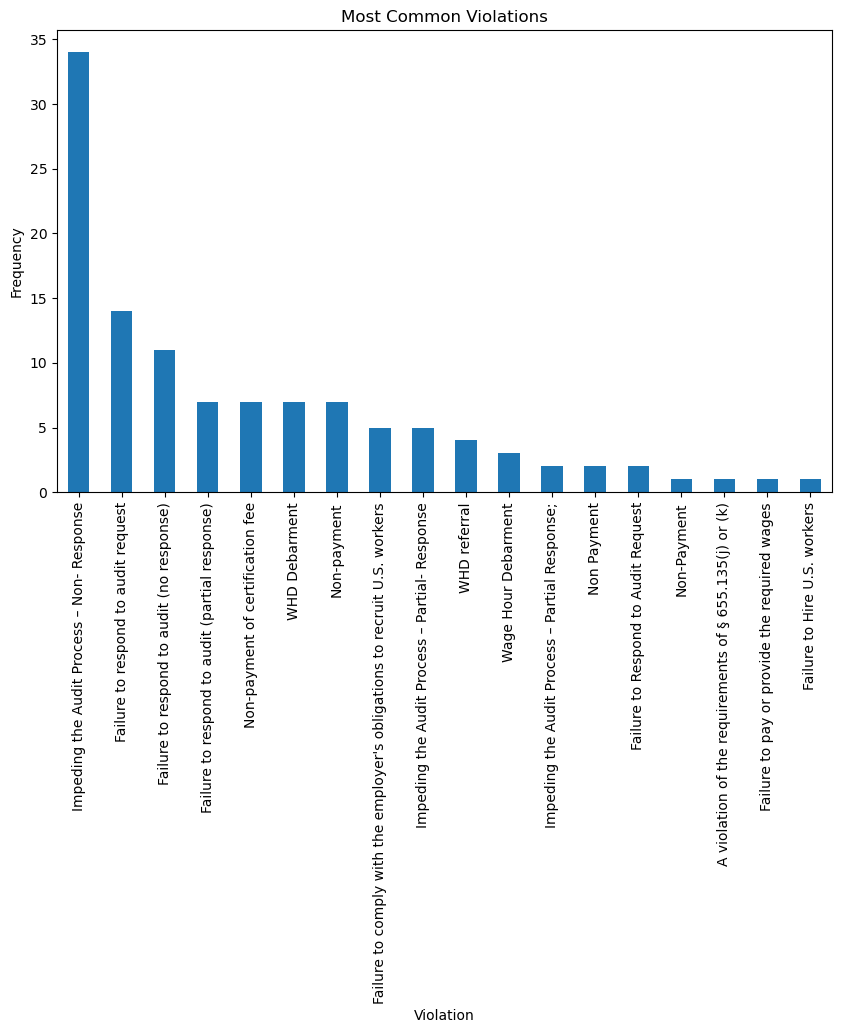

In [88]:
## create bar chart showing the most common violations

import matplotlib.pyplot as plt

# count each type of violation
freq_violation = debar['Violation'].value_counts()

# create plot
plt.figure(figsize = (10, 6))
freq_violation.plot(kind='bar')
plt.title('Most Common Violations')
plt.xlabel('Violation')
plt.ylabel('Frequency')
plt.show()